In [4]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from tensorflow.keras.utils import to_categorical

import sys
import deepchem as dc
import pandas as pd
from deepchem.molnet.load_function.molnet_loader import TransformerGenerator, _MolnetLoader

from deepchem.data import Dataset
from typing import List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

tf.compat.v1.disable_eager_execution()

In [5]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import catboost
from catboost import *
from catboost import datasets
feature_field="smiles"
TASKS = ['TOXRIC_Toxicity_Value', 'VirginiaSabando_Toxicity_Value']

In [6]:
task = "/Solution/Ames/train_ames.csv"
task_dir = "/Solution/Ames/"
task_save = "/Solution/Ames/"
df = pd.read_csv(task)
class MyLoader(_MolnetLoader):

    def create_dataset(self) -> Dataset:
        loader = dc.data.CSVLoader(tasks=self.tasks,
                                   feature_field=feature_field,
                                   featurizer=self.featurizer)
        return loader.create_dataset(task, shard_size=8192)


def load_tox21(
    featurizer: Union[dc.feat.Featurizer, str] = 'ECFP',
    splitter: Union[dc.splits.Splitter, str, None] = 'scaffold',
    transformers: List[Union[TransformerGenerator, str]] = ['balancing'],
    reload: bool = True,
    data_dir: Optional[str] = task_dir,
    save_dir: Optional[str] = task_save,
    **kwargs
) -> Tuple[List[str], Tuple[Dataset, ...], List[dc.trans.Transformer]]:
    
    loader = MyLoader(featurizer, splitter, transformers, TASKS,
                          data_dir, save_dir, **kwargs)
    return loader.load_dataset(task, reload)
tasks, datasets, transformers = load_tox21()
train_dataset, valid_dataset, test_dataset = datasets
df_tr = train_dataset.to_dataframe()

df_t = test_dataset.to_dataframe()
df_v = valid_dataset.to_dataframe()

In [7]:
x = df_tr.drop(['y1','w1','w2','ids'],axis=1)
y = df_tr['y1']
xt = df_t.drop(['y1','w1','w2','ids'],axis=1)
 
x_smiles = df_t['ids'].to_numpy()

yt = df_t['y1']
xv = df_v.drop(['y1','w1','w2','ids'],axis=1)

yv = df_v['y1']

In [8]:
input_len=len(x.iloc[0])

In [9]:
def set_seed(s):
    K.clear_session()
    seed_value= s
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)


In [10]:
set_seed(17)

In [11]:
def build_model(input_len, len1, len2, len3, regular, activ_f,momentum_batch_norm):

    #dropout
    prob_h1 = 0.25
    prob_h2 = 0.15
    prob_h3 = 0.1
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(input_len), dtype='float32'))
    model.add(keras.layers.Dense(len1, input_dim=input_len, kernel_regularizer = regular, activation=activ_f))
    model.add(keras.layers.BatchNormalization(momentum=momentum_batch_norm))
    model.add(keras.layers.Dropout(prob_h1))

    model.add(keras.layers.Dense(len2, kernel_regularizer = regular, activation=activ_f))
    model.add(keras.layers.BatchNormalization(momentum=momentum_batch_norm))
    model.add(keras.layers.Dropout(prob_h2))
    
    model.add(keras.layers.Dense(len2, kernel_regularizer = regular, activation=activ_f))
    model.add(keras.layers.BatchNormalization(momentum=momentum_batch_norm))
    model.add(keras.layers.Dropout(prob_h2))

    model.add(keras.layers.Dense(len3, kernel_regularizer = regular, activation=activ_f))
    model.add(keras.layers.BatchNormalization(momentum=momentum_batch_norm))
    model.add(keras.layers.Dropout(prob_h2))

    model.add(keras.layers.Dense(1,activation='sigmoid'))
    return model


In [12]:
reg = tf.keras.regularizers.l1_l2(0.0008,0.0008)
model = build_model(input_len,200,50,10,reg,'relu',0.9)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               205200    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________________________________________________

In [13]:
# opt = Adam(0.0001)
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['AUC'])
# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               205200    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [15]:
import matplotlib.pyplot as plt
def show_history(hist):
    acc = hist.history['AUC']
    val_acc = hist.history['val_AUC']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='AUC')
    plt.plot(epochs, val_acc, ':', label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

In [16]:
min_delta_val = 0.0005
patience_val = 1000

early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=min_delta_val, 
                              patience=patience_val, 
                              verbose=0, 
                              mode='min',
                              restore_best_weights=True)

In [17]:
hist = model.fit(x, y, validation_data=(xv, yv),
                 callbacks=[early_stop],
                 epochs=500, batch_size=80)



Train on 6529 samples, validate on 816 samples
Epoch 1/500
6240/6529 [===========================>..] - ETA: 0s - loss: 8.0646 - AUC: 0.4687

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


6529/6529 [==============================] - 3s 406us/sample - loss: 8.0647 - AUC: 0.4697 - val_loss: 7.9924 - val_AUC: 0.4441
Epoch 2/500
6529/6529 [==============================] - 1s 140us/sample - loss: 8.0301 - AUC: 0.4703 - val_loss: 7.9427 - val_AUC: 0.4666
Epoch 3/500
6529/6529 [==============================] - 1s 150us/sample - loss: 7.9777 - AUC: 0.4825 - val_loss: 7.9054 - val_AUC: 0.4847
Epoch 4/500
6529/6529 [==============================] - 1s 138us/sample - loss: 7.9349 - AUC: 0.5059 - val_loss: 7.8630 - val_AUC: 0.4967
Epoch 5/500
6529/6529 [==============================] - 1s 126us/sample - loss: 7.8810 - AUC: 0.5249 - val_loss: 7.8405 - val_AUC: 0.5126
Epoch 6/500
6529/6529 [==============================] - 1s 147us/sample - loss: 7.8640 - AUC: 0.5308 - val_loss: 7.8028 - val_AUC: 0.5289
Epoch 7/500
6529/6529 [==============================] - 1s 136us/sample - loss: 7.8212 - AUC: 0.5416 - val_loss: 7.7854 - val_AUC: 0.5412
Epoch 8/500
6529/6529 [================

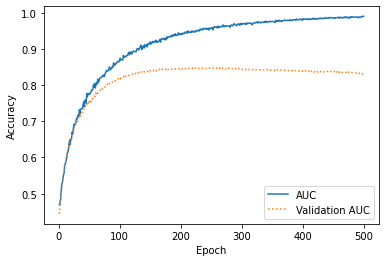

In [18]:
show_history(hist)

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yt,model.predict(xt))

0.7491515871017256

In [20]:
pred = np.where(model.predict(xt)>0.5,1,0)

In [21]:
df_savey = pd.DataFrame(data={'smiles':list(x_smiles)})
df_savey['y']=pred
df_savey.to_csv('output_classification_ames_nn.csv',index=False)  